# Code to calibrate DMD mirror wavelengths
- The idea is to raster across each column of mirrors and record the wavelength of reflected light changing
- Requires custom library 'seabreeze' to be installed https://python-seabreeze.readthedocs.io/en/latest/quickstart.html

## Imports

In [113]:
import seabreeze
from seabreeze.spectrometers import Spectrometer
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit

## Establish connection to spectrometer
- Ensure OceanART is now closed
- Only run this cell once, it will return an error otherwise
- Should show spectrometer USB4000:FLMT01856

In [2]:
spec = Spectrometer.from_first_available()
spec

<Spectrometer USB4000:FLMT01856>

## Set integration time and check spectrum

That took  0.033952951431274414  seconds


Text(0, 0.5, 'Intensity / a.u.')

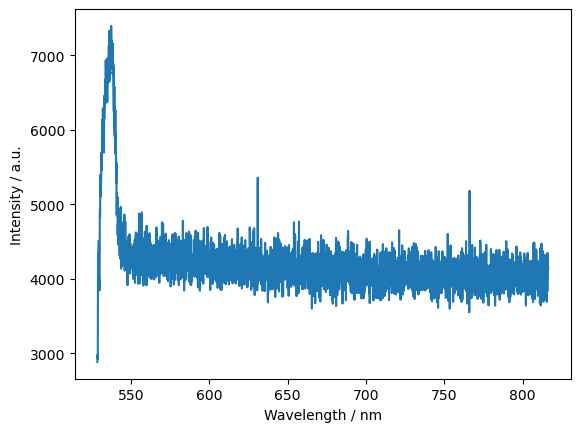

In [70]:
spec.integration_time_micros(8e5) # 0.9 s

ti = time.time()
intensities = spec.intensities()
tf = time.time()
print('That took ',tf-ti,' seconds')
plt.plot(wavelengths,intensities)
plt.xlabel('Wavelength / nm')
plt.ylabel('Intensity / a.u.')

## Extract wavelength positions

In [28]:
wavelengths = spec.wavelengths()
wavelengths

array([528.4295    , 528.52212501, 528.6147435 , ..., 816.2294228 ,
       816.29293044, 816.35642864])

## Acquire calibration dataset

- Prepare DMD patterns in Lightcrafter as described in instructions
- Ensure integration time here is a little less than the DMD exposure time
- This will then continuously acquire for 200 seconds (there are 191 patterns at 1s each)

In [85]:
ti = time.time()
keepgoing=True
all_spectra = []
while keepgoing == True:
    spectrum = spec.intensities()
    all_spectra.append(spectrum)
    tf = time.time()
    if tf-ti > 200:
        keepgoing = False

## Initial check to see if acquisition worked
- Should see peaks changing in colour, blue on the left and more orange on the right
- Note because of the limited range of the spectrometer, much of the acquisition will be <500 nm and not detected, so we can just use the first 115 or so acquisitions

In [87]:
len(all_spectra)

251

Text(0.5, 1.0, 'Color proportional to acquisition time')

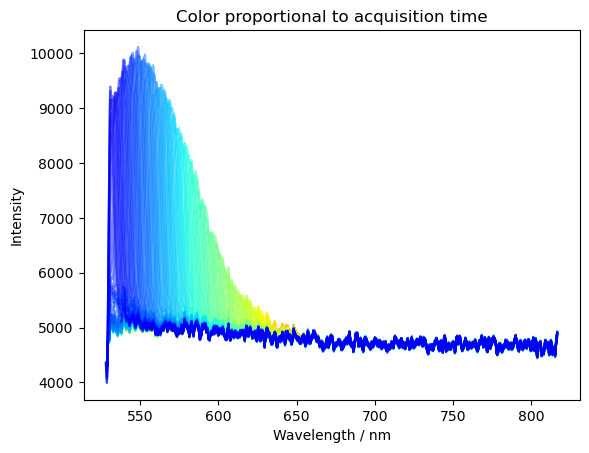

In [93]:
from scipy.signal import savgol_filter
import numpy as np
colors = plt.cm.jet_r(np.linspace(.2,.9,len(all_spectra[:115])))
for i,s in enumerate(all_spectra[:115]):
    yhat = savgol_filter(s, 30, 3,mode='constant',cval=np.mean(s))
    plt.plot(wavelengths,yhat,color=colors[i],alpha=.5)

plt.xlabel('Wavelength / nm')
plt.ylabel('Intensity')
plt.title('Color proportional to acquisition time')

## Save calibration data

In [118]:
# Save
df = pd.DataFrame(columns=wavelengths,data=all_spectra)
df.to_pickle(r'C:\Users\er407\Desktop\DMD demo\Calibration/calibration_23-04-28.pkl')

In [ ]:
# Load
df = pd.read_pickle(r'C:\Users\er407\Desktop\DMD demo\Calibration/calibration_23-04-28.pkl')
wavelengths = df.columns.values
all_spectra = df.values

## Extract peak wavelengths and plot
- Must specify the region which behaves linearly

Text(0, 0.5, 'Wavelength / nm')

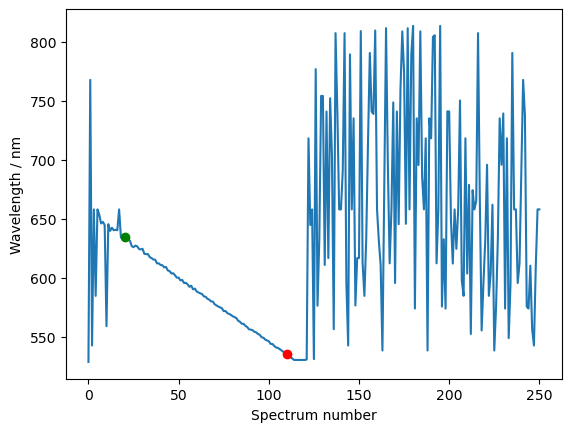

In [129]:
# assume first reading is ~ backround
bg = all_spectra[0]

# find peak at each step
xmaxs = []
for s in all_spectra:
    imax = np.argmax(s - bg)
    xmax = wavelengths[imax]
    xmaxs.append(xmax)

# Specify linear region
lin_region=(20,110)

plt.plot(xmaxs)
plt.plot(lin_region[0],xmaxs[lin_region[0]],'go')
plt.plot(lin_region[1],xmaxs[lin_region[1]],'ro')
plt.xlabel('Spectrum number')
plt.ylabel('Wavelength / nm')

## Fit model to the linear region

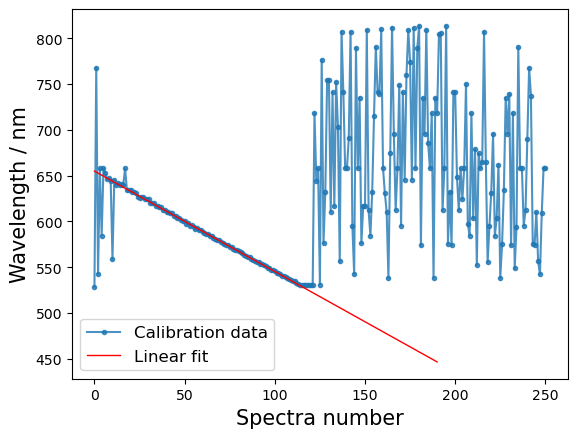

In [134]:
# extract linear region
xmaxs_lin = xmaxs[lin_region[0]:lin_region[1]]

# spectra were not sampled at exactly 1 per raster, figure out the oversampling ratio
n = 0
for i in range(len(xmaxs_lin)-1):
    if abs(xmaxs_lin[i] - xmaxs_lin[i+1]) < 0.5:
        n +=1

num_patterns = 191 # CHANGE IF DIFFERENT BINNING USED
count_ratio = count_ratio = num_patterns/len(xmaxs)

# fit straight line to linear region
def f(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

xfit = np.arange(lin_region[0],lin_region[1])
popt, pcov = curve_fit(f, xfit, xmaxs_lin) # your data x, y to fit

# extrapolate over full space
yfits = []
#

for x in np.arange(len(xmaxs)*count_ratio):
    yfit = f(x,popt[0],popt[1])
    yfits.append(yfit)

# take a look
plt.plot(xmaxs, '.-', alpha=.8, label = 'Calibration data')
plt.plot(yfits,'-',alpha=1,linewidth=1,color='r',label='Linear fit')

plt.xlabel('Spectra number',fontsize=15)
plt.ylabel('Wavelength / nm',fontsize=15)
plt.legend(fontsize=12)

Text(0, 0.5, 'Wavelength / nm')

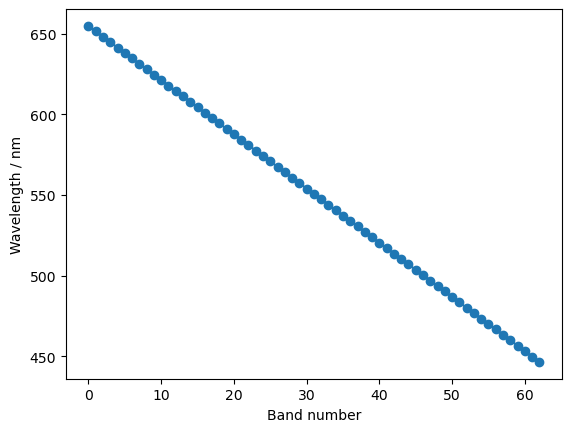

In [138]:
# Final extraction
nbands = 63 # resolution used in measurements
wavelengths = np.linspace(np.max(yfits),np.min(yfits),num=63)
plt.plot(wavelengths,'-o')
plt.xlabel('Band number')
plt.ylabel('Wavelength / nm')

In [141]:
# Save
yminmax = [np.min(yfits),np.max(yfits)]
np.save(r'C:\Users\er407\Desktop\DMD demo\Calibration/calibration_extracted_23-04-28',yminmax)

In [142]:
# Load
fpath = r'C:\Users\er407\Desktop\DMD demo\Calibration/calibration_extracted_23-04-28.npy'
yminmax = np.load(fpath)

In [145]:
# Function

def get_wavelengths(nbands=63, fpath=r'C:\Users\er407\Desktop\DMD demo\Calibration/calibration_extracted_23-04-28.npy'):
    yminmax = np.load(fpath)
    wavelengths = np.linspace(yminmax[1],yminmax[0],num=nbands)
    return wavelengths